In [32]:
"""
descr: 使用 LSTM 进行新冠病例预测（基于Pytorch机器学习框架）
author: lj.michale
date: 2021-12-31
"""

'\ndescr: 使用 LSTM 进行新冠病例预测（基于Pytorch机器学习框架）\nauthor: lj.michale\ndate: 2021-12-31\n'

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 6
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
# 我们将只使用确诊病例的时间序列数据(也提供死亡和康复病例数)
# 首先导入数据集
df = pd.read_csv('F:\\datasets\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/20/21,12/21/21,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21,12/27/21,12/28/21,12/29/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,157797,157816,157841,157878,157887,157895,157951,157967,157998,158037
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,205897,206273,206616,206935,207221,207542,207709,207709,208352,208899
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,214835,215145,215430,215723,216098,216376,216637,216930,217265,217647
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,21062,21062,21372,21571,21730,21730,21730,22332,22540,22823
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,66086,66566,67199,68362,70221,71142,71752,71752,76787,78475


In [5]:
# 这里要注意两点：
# 数据包含省、国家/地区、纬度和经度。但我们不需要这些数据。
# 病例数是累积的。我们需要撤消累积。
# 从去掉前四列我们不需要的数据，可以通过切片直接获取第五列之后的数据。

In [6]:
df = df.iloc[:, 4:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,12/20/21,12/21/21,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21,12/27/21,12/28/21,12/29/21
0,0,0,0,0,0,0,0,0,0,0,...,157797,157816,157841,157878,157887,157895,157951,157967,157998,158037
1,0,0,0,0,0,0,0,0,0,0,...,205897,206273,206616,206935,207221,207542,207709,207709,208352,208899
2,0,0,0,0,0,0,0,0,0,0,...,214835,215145,215430,215723,216098,216376,216637,216930,217265,217647
3,0,0,0,0,0,0,0,0,0,0,...,21062,21062,21372,21571,21730,21730,21730,22332,22540,22823
4,0,0,0,0,0,0,0,0,0,0,...,66086,66566,67199,68362,70221,71142,71752,71752,76787,78475


In [7]:
# 接下来检查缺失值
df.isnull().sum().sum()

0

In [8]:
# 一切都已就位。我们对所有行求和，这样就得到了每日累计案例：
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     557
2020-01-23     655
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

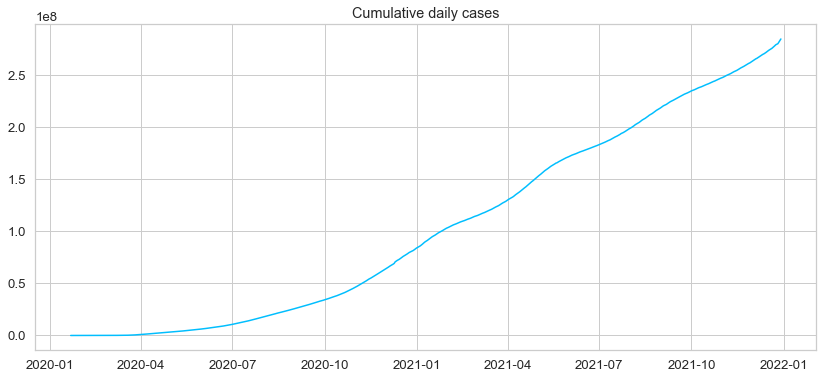

In [9]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [10]:
# 我们将通过从前一个值中减去当前值来撤消累加。我们将保留序列的第一个值。
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    557
2020-01-23     98
2020-01-24    286
2020-01-25    493
2020-01-26    684
dtype: int64

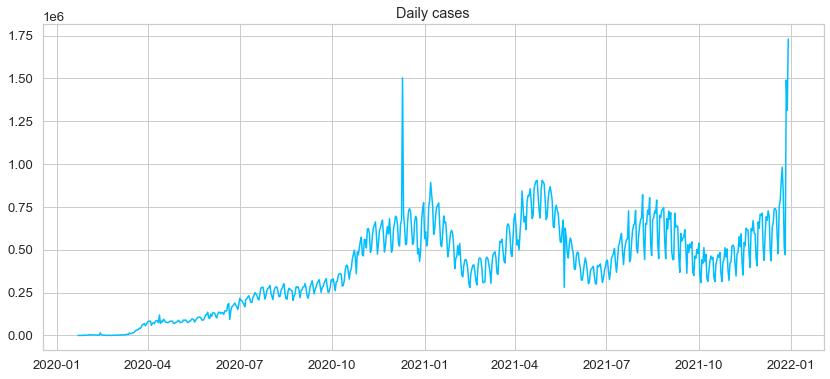

In [11]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [12]:
# 从图中可以看出有一个巨大的峰值，这主要是由于中国检测患者的标准发生了变化。这对我们的模型来说肯定是一个挑战。
# 让我们检查一下我们拥有的数据量。=> 我们有 708 天的数据。让我们看看我们能用它做什么。
daily_cases.shape

(708,)

In [13]:
# 数据预处理
# 我们将保留前 553天用于训练，其余时间用于测试。
test_data_size = 155
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data.shape

(553,)

In [14]:
# 如果我们想提高模型的训练速度和性能，我们必须缩放数据（将值按比例压缩在 0 和 1 之间）。我们将使用来自 scikit-learn 的MinMaxScaler。
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [15]:
# 这份数据中，每天都有大量的病例。可以将把它转换成更小的条数。
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 7
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [16]:
# 每个训练示例包含7个历史数据点序列和一个标签，该标签表示我们的模型需要预测的真实值。接下来看看我们转换后的数据的样貌。
X_train.shape

torch.Size([545, 7, 1])

In [17]:
X_train[:2]

tensor([[[0.0003],
         [0.0000],
         [0.0001],
         [0.0003],
         [0.0004],
         [0.0005],
         [0.0017]],

        [[0.0000],
         [0.0001],
         [0.0003],
         [0.0004],
         [0.0005],
         [0.0017],
         [0.0003]]])

In [18]:
y_train.shape

torch.Size([545, 1])

In [19]:
y_train[:2]

tensor([[0.0003],
        [0.0013]])

In [20]:
train_data[:10]

array([[0.00030525],
       [0.        ],
       [0.00012503],
       [0.00026269],
       [0.00038971],
       [0.00047284],
       [0.00169784],
       [0.00032653],
       [0.00131012],
       [0.00106007]])

In [22]:
# 建立模型
# 我们将把模型封装到一个自torch.nn.Module的类中。

# 我们CoronaVirusPredictor 包含 3 个方法：
# 构造函数 - 初始化所有辅助数据并创建层。
# reset_hidden_state - 我们将使用无状态 LSTM，因此我们需要在每个示例之后重置状态。
# forward- 获取序列，一次将所有序列通过 LSTM 层。我们采用最后一个时间步的输出并将其传递给我们的线性层以获得预测。
class CoronaVirusPredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [23]:
# 训练模型
# 为模型训练构建一个辅助函数
def train_model(
      model, 
      train_data, 
      train_labels, 
      test_data=None, 
      test_labels=None
    ):
    loss_fn = torch.nn.MSELoss(reduction='sum')

    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 100

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()

            if t % 10 == 0:  
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    return model.eval(), train_hist, test_hist

In [24]:
# 注意，隐藏层的状态在每个epoch开始时被重置。我们不使用批量的数据，模型可以一次看到每个样本。将使用均方误差来测量我们的训练和测试误差，并将两者都记录下来。

In [25]:
# 接下来创建一个模型的实例并训练它
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 40.90122604370117 test loss: 20.671436309814453
Epoch 10 train loss: 13.946430206298828 test loss: 5.261178016662598
Epoch 20 train loss: 11.793449401855469 test loss: 6.857668399810791
Epoch 30 train loss: 10.761844635009766 test loss: 4.7460126876831055
Epoch 40 train loss: 6.418435096740723 test loss: 8.518282890319824
Epoch 50 train loss: 4.817037582397461 test loss: 10.4010009765625
Epoch 60 train loss: 194.48916625976562 test loss: 91.5348129272461
Epoch 70 train loss: 15.395607948303223 test loss: 3.382284164428711
Epoch 80 train loss: 15.056966781616211 test loss: 3.6825406551361084
Epoch 90 train loss: 15.012513160705566 test loss: 5.636323928833008


In [26]:
# 如何解决神经网络训练时loss不下降的问题？
# 训练集loss不下降
# 1.模型结构和特征工程存在问题
# 2.权重初始化方案有问题
# 3.正则化过度
# 4.选择合适的激活函数、损失函数
# 5.选择合适的优化器和学习速率
# 6.训练时间不足
# 7.模型训练遇到瓶颈：梯度消失、大量神经元失活、梯度爆炸和弥散、学习率过大或过小等
# 8.batch size过大
# 9.数据集未打乱
# 10.数据集有问题
# 11.未进行归一化
# 12.特征工程中对数据特征的选取有问题
# 验证集loss不下降
# 1.适当的正则化和降维
# 2.适当降低模型的规模
# 3.获取更多的数据集

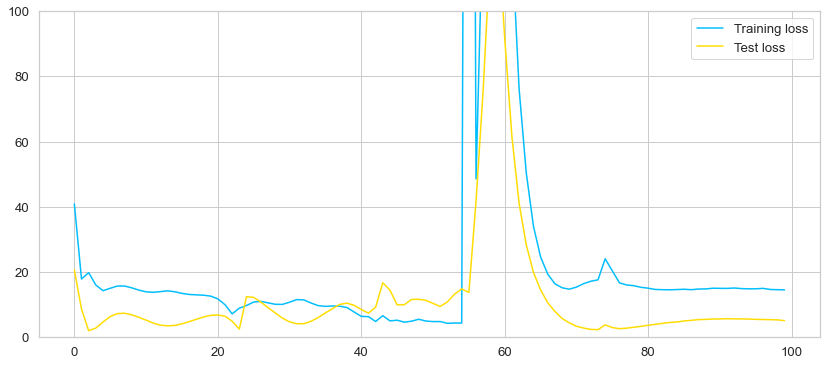

In [27]:
# 来看看训练和测试损失
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 100))
plt.legend();

In [28]:
# 我们的模型在50个时代之后并没有改善。回想一下，我们只有很少的数据，并且模型损失并未优化至最佳。也许我们不该那么相信我们的模型？

In [29]:
# 预测未来几天的病例
# 我们的所建立的模型（由于训练它的方式）只能预测未来的某一天。我们将采用一个简单的策略来克服这个限制。使用预测值作为预测未来几天的输入
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq
                   ).view(1, seq_length, 1).float()

In [30]:
# 这里需要撤销测试数据和模型预测的缩放转换比例，即使用逆缩放器变换，已得到原始数据
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

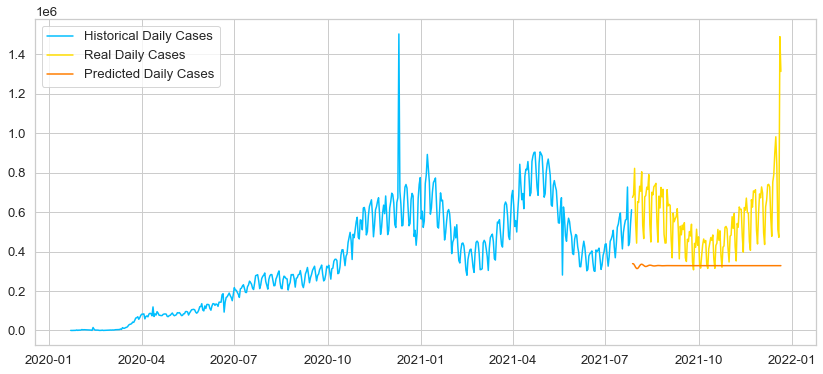

In [31]:
# 一起看看结果，将训练数据、测试数据及预测数据绘制在同一张画布上，一起比较下预测结果
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases')

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases')

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases')

plt.legend();

In [33]:
# 正如预期的那样，我们的模型表现不佳。也就是说，预测似乎是正确的（可能是因为使用最后一个数据点作为下一个数据点的强预测器）。
# 使用所有数据来训练
# 现在，我们将使用所有可用数据来训练相同的模型
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(708, 1)

In [34]:
# 预处理和训练步骤相同
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 31.017967224121094
Epoch 10 train loss: 14.253035545349121
Epoch 20 train loss: 13.247159004211426
Epoch 30 train loss: 8.343362808227539
Epoch 40 train loss: 14.751494407653809
Epoch 50 train loss: 13.22626781463623
Epoch 60 train loss: 11.59303092956543
Epoch 70 train loss: 7.359367847442627
Epoch 80 train loss: 3.6629421710968018
Epoch 90 train loss: 3.6353983879089355


In [35]:
# 预测未来病例
# 使用“完全训练”的模型来预测未来 12 天的确诊病例
DAYS_TO_PREDICT = 12

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [36]:
# 和以前一样，我们将逆缩放器变换
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [37]:
# 要使用历史和预测案例创建一个很酷的图表，我们需要扩展数据框的日期索引
daily_cases.index[-1]

Timestamp('2021-12-29 00:00:00')

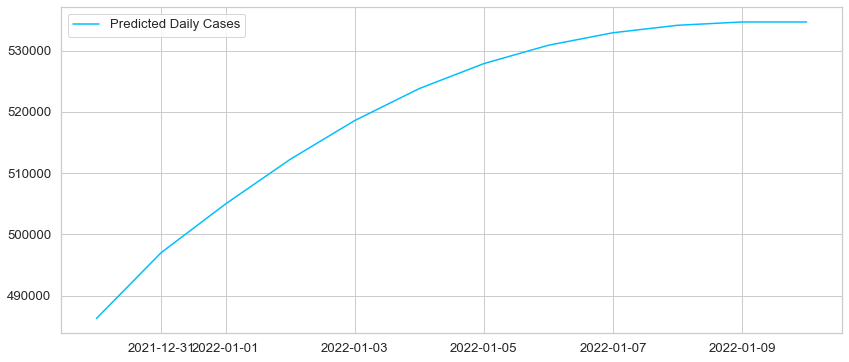

In [38]:
predicted_index = pd.date_range(
  start = daily_cases.index[-1],
  periods = DAYS_TO_PREDICT + 1,
  closed = 'right'
)

predicted_cases = pd.Series(
  data = predicted_cases,
  index = predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

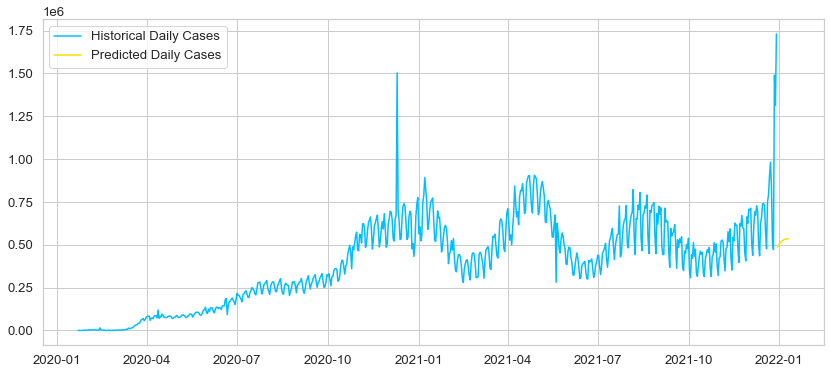

In [39]:
# 现在我们可以使用所有数据来绘制结果
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [40]:
# 从这里也能看，本次模型仍然有待优化。至于如何优化模型，待后续更新

In [41]:
# 写在最后
# 我们学习了如何使用 PyTorch 创建处理时间序列数据的循环神经网络。模型性能不是很好，但考虑到数据量很少，这是可以预期的
# 预测每日 Covid-19 病例的问题确实是一个难题。同样希望一段时间后一切都会恢复正常